# FAKE AND TRUE NEWS

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.sparse import hstack
from datetime import datetime
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, accuracy_score

Using TensorFlow backend.


__All the weights are calculated on only 80% of data.__

__I'm using LSTM as best model becuase its test accuracy is 100%.__

In [2]:
def decontract_months(phrase):
    # specific
    #phrase = phrase.lower()
    phrase = re.sub(r"jan", "january", phrase)
    phrase = re.sub(r"feb", "february", phrase)
    phrase = re.sub(r"mar", "march", phrase)
    phrase = re.sub(r"apr", "april", phrase)
    phrase = re.sub(r"jun", "june", phrase)
    phrase = re.sub(r"jul", "july", phrase)
    phrase = re.sub(r"aug", "august", phrase)
    phrase = re.sub(r"sep", "september", phrase)
    phrase = re.sub(r"oct", "october", phrase)
    phrase = re.sub(r"nov", "november", phrase)
    phrase = re.sub(r"dec", 'december',phrase)
    return phrase

In [3]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

## Preprocessing function

In [5]:
def entire_preprocessing(x):
    x.drop_duplicates(subset=['text'],keep='first',inplace=True)
    if x.isnull() is True:
        x.fillna('nan', inplace=True)
        
    months=['january','february','march','april','may','june','july','august','september','october','november','december']
    
    preprocessed_date=[]
    for sent in x['date'].values:
        sent=sent.lower()
        if sent.split()[0] not in months:
            sent=decontract_months(sent)
        sent=re.sub("https\S+","nan",sent)
        sent=sent.replace(',','')
        sent='_'.join(e for e in sent.split())
        preprocessed_date.append(sent)
    x['date']=preprocessed_date
    
    if x[x['date']=='nan'] is True:
        x.drop(x[x['date']=='nan'].index,inplace=True)
    
    def preprocess_fun(preprocess):
        preprocessed_text = []
        for sentance in preprocess:
            sent = decontracted(sentance)
            sent = re.sub('@\S+', ' ', sent)
            sent = re.sub('bit\S+', ' ', sent)
            sent=re.sub('https\S+',' ',sent)
            sent=re.sub('[^A-Za-z0-9]', ' ', sent)
            sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
            preprocessed_text.append(sent)
        return preprocessed_text
    
    x['text']=preprocess_fun(x['text'])
    x['title']=preprocess_fun(x['title'])
    
    return x

## Predicting function

In [6]:
def predicting_function(x_new):
    start = datetime.now()
    
    x = entire_preprocessing(x_new)# preprocessing of data
    
    subject = pd.read_pickle("data/count_subject.pickle")
    x_subject = subject.transform(x['subject']).toarray()#vectorizing subject data
    
    date = pd.read_pickle("data/count_date.pickle")
    x_date = date.transform(x['date']).toarray()#vectorizing date data
    
    text = pd.read_pickle("data/lstm_text_weight.pickle")
    x_text_encoded = text.texts_to_sequences(x['text'])#vectorizing text data
    x_text_padded = pad_sequences(x_text_encoded, maxlen = 500)
    
    title = pd.read_pickle("data/lstm_title_weight.pickle")
    x_title_encoded = title.texts_to_sequences(x['title'])#vectorizing title data
    x_title_padded = pad_sequences(x_title_encoded, maxlen = 100)
    
    
    model = load_model("lstm_model.h5")
    y = model.predict([x_text_padded, x_title_padded, x_subject, x_date])
    
    lst=[]
    for ele in y:
        lst.append(np.argmax(ele))
    
    print("So the total time taken to run this code:", (datetime.now() - start))
    
    return np.array(lst)

## Metric function

In [7]:
def metrics_function(x_new):
    start = datetime.now()
    
    x = entire_preprocessing(x_new)# preprocessing of data
    
    subject = pd.read_pickle("data/count_subject.pickle")
    x_subject = subject.transform(x['subject']).toarray()#vectorizing subject data
    
    date = pd.read_pickle("data/count_date.pickle")
    x_date = date.transform(x['date']).toarray()#vectorizing date data
    
    text = pd.read_pickle("data/lstm_text_weight.pickle")
    x_text_encoded = text.texts_to_sequences(x['text'])#vectorizing text data
    x_text_padded = pad_sequences(x_text_encoded, maxlen = 500)
    
    title = pd.read_pickle("data/lstm_title_weight.pickle")
    x_title_encoded = title.texts_to_sequences(x['title'])#vectorizing title data
    x_title_padded = pad_sequences(x_title_encoded, maxlen = 100)
    
    model = load_model("lstm_model.h5")
    y = model.predict([x_text_padded, x_title_padded, x_subject, x_date])
    
    
    y_true = x['label']
    y_pred=[]
    for ele in y:
        y_pred.append(np.argmax(ele))
        
    
    print("="*50)
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy: {}%".format(accuracy*100))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm,annot=True,fmt='d')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title("Confusion matrix")
    
    print("="*50)
    print("So the total time taken to run this code:", (datetime.now() - start))
    print("="*50)

## Loading Data

In [8]:
#loading fake data
fake_data=pd.read_csv('Fake.csv')
la=[]
for i in range(fake_data.shape[0]):#label = 0 for fake news
    la.append(0)
la=pd.DataFrame(la)
la.columns=['label']
df_fake=pd.concat([fake_data,la],axis=1)

In [9]:
#loading true data
true_data=pd.read_csv('True.csv')
lb=[]
for i in range(true_data.shape[0]):# label = 1 for true news
    lb.append(1)
lb=pd.DataFrame(lb)
lb.columns=['label']
df_true=pd.concat([true_data,lb],axis=1)

In [10]:
#concatenating true news and fake news
final_data=pd.concat([df_true,df_fake],axis=0)#concatenating all the data
print(final_data.shape)

(44898, 5)


### Predicting on whole dataset

In [11]:
y_pred = predicting_function(final_data)

So the total time taken to run this code: 0:01:41.142557


In [12]:
print(y_pred)

[1 1 1 ... 0 0 0]


### Performance Metrics

Accuracy: 100.0%
So the total time taken to run this code: 0:01:31.591982


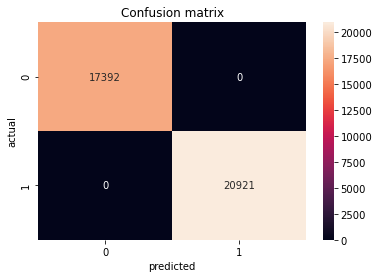

In [13]:
metrics_function(final_data)